In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.sample import *

## Inference of intergalactic magnetic field
Here we infer the index $\alpha$ relation magnetic field strength to over-density in the IGM (see _notebooks/model/IGM.ipynb_)
$$|B|\propto \rho^\alpha .$$
This is done by a combined inference of DM and RM, obtaining the likelihood of source redshift from DM (see _notebooks/RedshiftEstimate.ipynb_) providing more detailed investigation of the likelihood of $\alpha$ from RM.
Thus, our approach exploits the full information entailed in each measure instead of reducing to their ratio. 
Comparing estimates of different choices of $\alpha$ in our benchmark scenario, we show that FRBs potentially probe the IGMF down to current lower limits set by Neronov & Vovk 2011.

Since RM depends on IGM baryon content $f_{\rm IGM}$, just as DM does (see _notebooks/joint-analysis__fIGM-population.ipynb_), the combined inference of $\alpha$ and $f_{\rm IGM}$ is erratic.
We thus consider the case that a good estimate on $f_{\rm IGM} \approx 0.9$ is provided by the much richer sample of FRB observed without reasonable extragalactic RM.
Further, for the case of such high $f_{\rm IGM}$ we found the redshift distribution following SMD to produce the best results, thus assume this here too.

Since no sufficient sample of FRBs with RM is available as of yet, we investigate the required size of that sample to improve on current constraints on the IGMF.


In [2]:
## realistic benchmark scenario
from PreFRBLE.Scenario import scenario_benchmark as scenario

## investigated range of alpha
alphas = np.arange(1.,9.1,1.0)/3


In [3]:
tmp = Scenario( telescope='CHIME', population='SMD', **scenario.Properties( identifier=False ) )
DMs=[200.,300.]
RMs = [10.,20.]
TimeElapsed( LikelihoodCombined,  measures=['DM','RM'], datas=[DMs,RMs], scenario=tmp, measureable=True )

/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/LikelihoodFunction.py:176: RuntimeWarning: divide by zero encountered in power
  self.dev =  ( self.Probability()*N )**-0.5


LikelihoodCombined took 0.4156804084777832 s


array([1.37786214e-08, 1.35271029e-08])

Assuming $f_{\rm IGM} = 0.9$, $\alpha=9/3$ and population=SMD, we use mock catalogs of increasing size to see how many FRBs observed with CHIME are required to derive an upper limit on the IGMF-density-relation $\alpha$.


In [4]:
from multiprocessing import Pool
from functools import partial

## first define a picklable function
def MockIGMF( N, measureable=True, scenario=False):
    
    ## prepare mock sample
    FRBs_mock = FakeFRBs( measures=['DM','RM'], N=N, measureable=measureable, scenario=scenario )
    DMs, RMs, zs = [FRBs_mock[v] for v in ['DM','RM', 'redshift'] ]

    ## container for results
    bayes = np.zeros_like(alphas)
    
    ## compute likelihood for reference model
    P0 = LikelihoodCombined( measures=['DM','RM'], datas=[DMs,RMs], scenario=scenario, measureable=measureable )
    
    ## compare to likelihood for different choices of alpha
    for i_a, alpha in enumerate( alphas ):
        tmp = scenario.copy()
        tmp.IGM = 'alpha{:.0f}-3rd'.format(alpha*3)
        bayes[i_a] = 1 if tmp == scenario else np.prod( LikelihoodCombined( measures=['DM','RM'], datas=[DMs,RMs], scenario=tmp, measureable=measureable ) / P0 )

    return bayes


#### !!! this takes a little while

In [5]:


alpha = 9./3
population = 'SMD'
telescope = 'CHIME'


scenario_ref = Scenario( telescope=telescope, population=population, **scenario.Properties(identifier=False) )
scenario_ref.IGM = 'alpha{:.0f}-3rd'.format(alpha*3)

tries = 2 #10 # number of repetitions to obtain error on bayes factors
N_N = 3 #10  # number of steps
N_min, N_max = 1, 3.5 #4.5 ## log ## min and max step
Ns = (10.**np.linspace(N_min,N_max,N_N)).astype('i')

measureable = True # consider that RM < RM_min are not observable?

Bayes = np.zeros( [ len(alphas), len(Ns) ] )
Bayes_dev = np.zeros( [ 2, len(alphas), len(Ns) ] )

p = Pool(2)
f = partial( MockIGMF, scenario=scenario_ref )


#for i_N, N in enumerate(Ns):
for i_N in trange(len(Ns )):
    N = Ns[i_N]
    bayes = p.map( f, [N]*tries )
    bayes = np.array(bayes).T
    Bayes[:,i_N], Bayes_dev[:,:,i_N] = LogMeanStd( bayes, axis=1 )

  0%|          | 0/3 [00:00<?, ?it/s]/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/LikelihoodFunction.py:176: RuntimeWarning: divide by zero encountered in power
  self.dev =  ( self.Probability()*N )**-0.5
/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/LikelihoodFunction.py:176: RuntimeWarning: divide by zero encountered in power
  self.dev =  ( self.Probability()*N )**-0.5
100%|██████████| 3/3 [02:35<00:00, 51.85s/it]


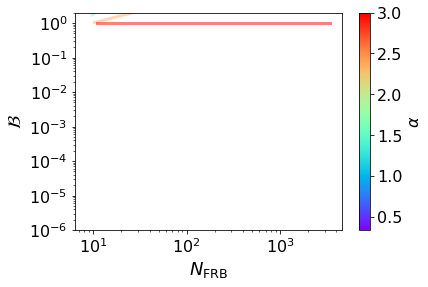

In [6]:
## plot results

fig, ax = plt.subplots()
plt.loglog()
for i_a, color in enumerate( Rainbow(alphas) ):
    if i_a % 2:
        continue
    plt.errorbar( Ns*(1-0.15+0.03*i_a), Bayes[i_a], yerr=Bayes_dev[:,i_a], color=color, alpha=0.5, lw=3 )
    alpha = alphas[i_a]

    
#for x, y, alpha in zip( [2e1, 2e2, 1e3, 5e3], [1e-6,1e-6,1e-6,1e-6],  alphas[alphas<5./3] ):
#    plt.text( x, y, r"$\alpha=\frac{{{:.0f}}}{{3}}$".format(alpha*3), fontsize=16)    
#plt.text( 3e3, 1e-1, r"$\alpha \geq \frac{{5}}{{3}}$", fontsize=16)    

Colorbar( alphas, label=r"$\alpha$" )
plt.xlabel( r"$N_{\rm FRB}$", fontdict={'size':18 } )
plt.ylabel( r"$\mathcal{B}$", fontdict={'size':18 } )
plt.ylim(1e-6,2)
#PlotLimit(ax=ax, x=[Ns[0],Ns[-1]], y=[1e-2,1e-2], lower_limit=False, label='ruled out', arrow_number=3, shift_text_vertical=-9e-3, shift_text_horizontal=-8.99e2)
ax.tick_params(axis='both', which='major', labelsize=16)
AllSidesTicks(ax)
plt.show()

In [7]:
Bayes

array([[6.88942885e+000, 6.95314891e+016, 1.24702182e+293],
       [5.13792632e+000, 2.49127605e+010, 8.81062700e+185],
       [2.30752326e+000, 5.98242935e+006, 3.82757634e+121],
       [2.29298258e+000, 3.38754266e+004, 3.77990563e+080],
       [1.72742570e+000, 5.31843302e+002, 4.26173114e+052],
       [1.21666693e+000, 7.69404105e+001, 4.71742403e+031],
       [1.03389926e+000, 7.75807239e+000, 4.30292246e+014],
       [1.41413835e+000, 6.84950810e+000, 6.74940593e+011],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000]])

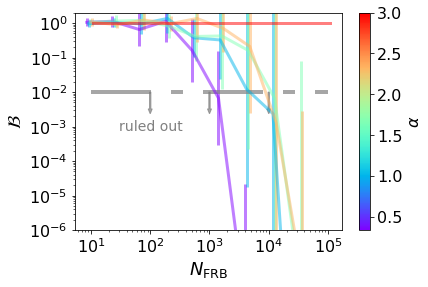

In [37]:
## plot results

fig, ax = plt.subplots()
plt.loglog()
for i_a, color in enumerate( Rainbow(alphas) ):
    if i_a % 2:
        continue
    plt.errorbar( Ns*(1-0.15+0.03*i_a), Bayes[i_a], yerr=Bayes_std[:,i_a], color=color, alpha=0.5, lw=3 )
    alpha = alphas[i_a]

    
#for x, y, alpha in zip( [2e1, 2e2, 1e3, 5e3], [1e-6,1e-6,1e-6,1e-6],  alphas[alphas<5./3] ):
#    plt.text( x, y, r"$\alpha=\frac{{{:.0f}}}{{3}}$".format(alpha*3), fontsize=16)    
#plt.text( 3e3, 1e-1, r"$\alpha \geq \frac{{5}}{{3}}$", fontsize=16)    

Colorbar( alphas, label=r"$\alpha$" )
plt.xlabel( r"$N_{\rm FRB}$", fontdict={'size':18 } )
plt.ylabel( r"$\mathcal{B}$", fontdict={'size':18 } )
plt.ylim(1e-6,2)
PlotLimit(ax=ax, x=[Ns[0],Ns[-1]], y=[1e-2,1e-2], lower_limit=False, label='ruled out', arrow_number=3, shift_text_vertical=-9e-3, shift_text_horizontal=-8.99e2)
ax.tick_params(axis='both', which='major', labelsize=16)
AllSidesTicks(ax)
plt.show()

Here is shown the resulting Bayes factor $\mathcal{B}$, comparing given value of $\alpha$ to $\alpha=\frac[9}{3}$, as function of mock sample size.
We assume all $\alpha$ to be equal likely, thus $\mathcal{B}$ also represents the ratio of posterior.
Thus, for $\mathcal(\alpha) < 10^{-2}$, $\alpha$ is ruled out decisively with 99% certainty.
The result shows that 1000-2000 FRBs at least have to be observed with $\rm RM_{EG} \geq 1 ~rad ~m^{-2}$ in order to to rule out $\alpha=\frac{1}{3}$, which corresponds to strongest IGMFs.
Thus, more than a thousand FRBS with $\rm RM_{EG} > 1 ~ rad~ m^{-2}$ mneed tobe observed in order to improve on current limits on the IGMF.
However, most values of $\alpha < \frac{9}{3}$ can likely be ruled out with few $10^4$, certainly with $10^5$ FRBs with reasonable extragalactic RM.
Obviously, this conclusion higly depends on the assumptions and might change considering different models.
Still, it certainly shows the potential of FRBs to constrain the IGMF with unprecedented precision, once SKA provides a huge sample of systematically observed FRBs.